In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
df = pd.read_csv('/content/cafethai_prices.csv', parse_dates=['date'], date_format='%d/%m/%Y')
display(df.head())


,date,time,cash_type,coffee_name,money
0,2023-03-01,08:04:19,card,Latte,75
1,2023-03-01,08:08:54,cash,Americano with Milk,70
2,2023-03-01,08:09:03,card,Cappuccino,75
3,2023-03-01,08:10:26,cash,Cappuccino,75
4,2023-03-01,08:15:37,cash,Cappuccino,75


In [27]:
df.set_index('date', inplace=True)

df.head()

,time,cash_type,coffee_name,money
date,,,,
2023-03-01,08:04:19,card,Latte,75
2023-03-01,08:08:54,cash,Americano with Milk,70
2023-03-01,08:09:03,card,Cappuccino,75
2023-03-01,08:10:26,cash,Cappuccino,75
2023-03-01,08:15:37,cash,Cappuccino,75


In [52]:
daily_item = (
    df.groupby([ITEM_COL, df.index.date])
      .size()
      .reset_index(name=TARGET_COL)
      .rename(columns={'level_1': 'date_only'})
)
daily_item['date_only'] = pd.to_datetime(daily_item['date_only'])
daily_item = daily_item.sort_values(['date_only', ITEM_COL])

display(daily_item.head())

,coffee_name,date_only,cups
0,Americano,2023-03-01,19
790,Americano with Milk,2023-03-01,27
1581,Cappuccino,2023-03-01,24
2365,Cocoa,2023-03-01,7
3126,Cortado,2023-03-01,14


In [53]:

daily_item = (
    df.groupby(['coffee_name', df.index.date])
      .size()
      .reset_index(name='cups')
      .rename(columns={'level_1':'date_only'})
)
daily_item['date_only'] = pd.to_datetime(daily_item['date_only'])


avg_daily = daily_item.groupby('coffee_name')['cups'].mean()
forecast_60d = avg_daily * 60
print("Simple average-based 60-day forecast:")
print(forecast_60d)

Simple average-based 60-day forecast:
coffee_name
Americano               821.924051
Americano with Milk    1149.481669
Cappuccino              742.882653
Cocoa                   351.248357
Cortado                 421.241915
Espresso                221.915493
Hot Chocolate           418.677043
Latte                  1121.719343
Name: cups, dtype: float64


In [63]:
def create_features(df_ts, target_col):
    ts = df_ts.set_index('date_only').asfreq('D').copy()
    ts[target_col] = ts[target_col].fillna(0)
    ts['dayofweek'] = ts.index.dayofweek
    ts['month']     = ts.index.month
    ts['lag_7']     = ts[target_col].shift(7)
    ts['rolling_mean_7'] = ts[target_col].shift(1).rolling(7).mean()
    ts = ts.dropna()
    FEATURES = ['dayofweek','month','lag_7','rolling_mean_7']
    return ts, FEATURES


In [64]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error
import pandas as pd

def fit_and_forecast_per_item_lite(df_all, item_name, model_type='xgb', forecast_days=60, split_ratio=0.85):
    sub = df_all[df_all['coffee_name']==item_name][['date_only','cups']].copy()
    if sub.empty: return None
    ts, FEATURES = create_features(sub, 'cups')
    n = len(ts)
    if n < 30: return None

    split_idx = int(n*split_ratio)
    Xtr, ytr = ts[FEATURES].iloc[:split_idx], ts['cups'].iloc[:split_idx]
    Xte, yte = ts[FEATURES].iloc[split_idx:], ts['cups'].iloc[split_idx:]

    if model_type=='rf':
        model = RandomForestRegressor(n_estimators=300, random_state=42)
        model_name = 'RandomForest'
    else:
        model = xgb.XGBRegressor(n_estimators=400, learning_rate=0.05, max_depth=6,
                                 subsample=0.9, colsample_bytree=0.9, random_state=42)
        model_name = 'XGBoost'
    model.fit(Xtr, ytr)
    mae = mean_absolute_error(yte, model.predict(Xte))

    last = ts.index.max()
    fut_idx = pd.date_range(last + pd.Timedelta(days=1), periods=forecast_days, freq='D')
    fut_feat = pd.DataFrame(index=fut_idx)

    fut_feat['dayofweek'] = fut_feat.index.dayofweek
    fut_feat['month']     = fut_feat.index.month

    tail = ts[['cups']].tail(14).copy()
    tail['dayofweek'] = tail.index.dayofweek
    tail['month']     = tail.index.month
    tmp = pd.concat([tail, fut_feat], axis=0)
    tmp['lag_7'] = tmp['cups'].shift(7)
    tmp['rolling_mean_7'] = tmp['cups'].shift(1).rolling(7).mean()
    futX = tmp.loc[fut_idx, ['dayofweek','month','lag_7','rolling_mean_7']].fillna(0)

    fut_pred = model.predict(futX)
    forecast_df = pd.DataFrame({'forecast': fut_pred}, index=fut_idx)
    history_df = ts[['cups']].rename(columns={'cups':'actual'})

    return {'item': item_name, 'model_name': model_name, 'mae': mae,
            'history': history_df, 'test_range': Xte.index,
            'forecast': forecast_df, 'model': model}


In [65]:
ITEM_COL = 'coffee_name'
FORECAST_DAYS = 60

items = daily_item[ITEM_COL].unique().tolist()
results_per_item = {}

for it in items:
    r_x = fit_and_forecast_per_item_lite(daily_item, it, 'xgb', FORECAST_DAYS)
    r_r = fit_and_forecast_per_item_lite(daily_item, it, 'rf',  FORECAST_DAYS)
    if r_x is None and r_r is None:
        continue
    pick = r_x if (r_r is None or (r_x and r_x['mae']<=r_r['mae'])) else r_r
    results_per_item[it] = pick

import pandas as pd
mae_table = pd.DataFrame([
    {'item': it, 'model': r['model_name'], 'MAE': r['mae']}
    for it, r in results_per_item.items()
]).sort_values('MAE')
display(mae_table.head(10))


,item,model,MAE
5,Espresso,RandomForest,1.673593
3,Cocoa,RandomForest,2.486311
6,Hot Chocolate,RandomForest,2.731525
4,Cortado,RandomForest,2.806818
0,Americano,RandomForest,4.066479
2,Cappuccino,RandomForest,4.239696
7,Latte,RandomForest,4.737274
1,Americano with Milk,XGBoost,4.993213


In [66]:

items = daily_item['coffee_name'].unique().tolist()
results_per_item = {}

if 'FORECAST_DAYS' not in locals():
    FORECAST_DAYS = 60

for it in items:

    r_xgb = fit_and_forecast_per_item_lite(daily_item, it, model_type='xgb', forecast_days=FORECAST_DAYS)
    r_rf  = fit_and_forecast_per_item_lite(daily_item, it, model_type='rf',  forecast_days=FORECAST_DAYS)

    if r_xgb is None and r_rf is None:
        continue

    if r_rf is None or (r_xgb and r_xgb['mae'] <= r_rf['mae']):
        results_per_item[it] = r_xgb
    else:
        results_per_item[it] = r_rf

print(f"จำนวนเมนูที่พยากรณ์ได้: {len(results_per_item)}")




จำนวนเมนูที่พยากรณ์ได้: 8


In [57]:
if results_per_item:
    mae_table = pd.DataFrame([
        {'item': it, 'model': res['model_name'], 'MAE': res['mae']}
        for it, res in results_per_item.items()
    ]).sort_values('MAE')
    display(mae_table.head(10))
else:
    print("No items were forecasted successfully.")

,item,model,MAE
4,Cortado,RandomForest,1.785889
5,Espresso,RandomForest,1.825333
3,Cocoa,RandomForest,1.829778
2,Cappuccino,RandomForest,2.615889
6,Hot Chocolate,RandomForest,2.738222
0,Americano,RandomForest,3.152444
7,Latte,XGBoost,4.495753
1,Americano with Milk,RandomForest,4.796333


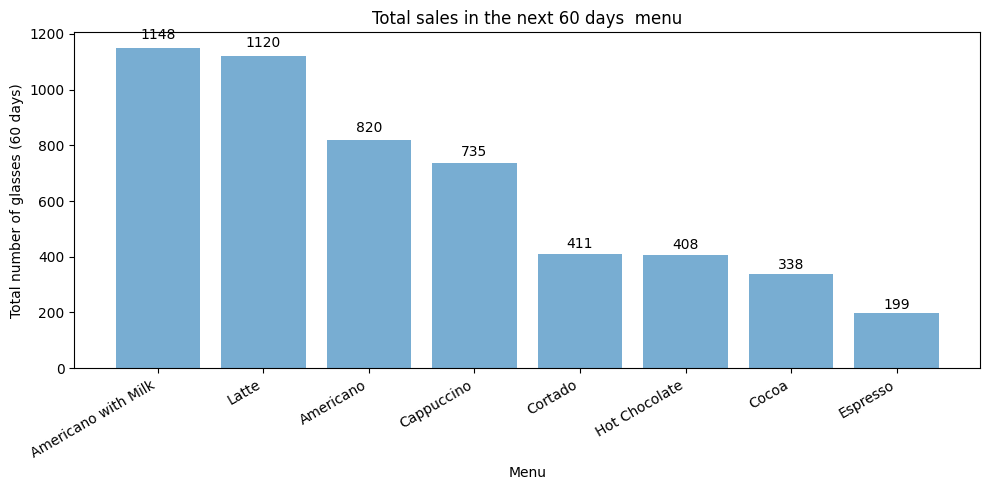

In [70]:
continuous = []
for it, g in daily_item.groupby('coffee_name'):
    s = g.set_index('date_only')['cups'].asfreq('D', fill_value=0)
    continuous.append(s.rename(it))
continuous = pd.concat(continuous, axis=1)
avg_daily = continuous.mean(axis=0)

forecast_60d = (avg_daily * 60).sort_values(ascending=False)

plt.figure(figsize=(10,5))
plt.bar(forecast_60d.index, forecast_60d.values, alpha=0.6)

for i, v in enumerate(forecast_60d.values):
    offset = max(v * 0.02, 1)
    plt.text(i, v + offset, f'{v:.0f}', ha='center', va='bottom')

plt.title('Total sales in the next 60 days  menu')
plt.xlabel('Menu'); plt.ylabel('Total number of glasses (60 days)')
plt.xticks(rotation=30, ha='right')
plt.ylim(bottom=0)
plt.tight_layout(); plt.show()